In [77]:
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix


train = pd.read_csv("cs-training.csv")

In [2]:
train.shape

(150000, 12)

In [3]:
train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
train.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [5]:
from collections import Counter
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(train,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "Unnamed: 0",
                                            "NumberOfDependents"])


In [6]:
train.loc[Outliers_to_drop]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
900,901,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,920,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
1958,1959,0,1.634551,28,0,151.000000,NaN,1,3,0,2,0.0
4852,4853,0,1.566866,46,2,0.104983,6000.0,3,2,0,0,0.0
5956,5957,0,2.237856,60,6,2597.000000,1.0,16,1,2,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117338,117339,1,0.960692,42,0,1.241580,3770.0,29,1,2,1,3.0
126682,126683,1,0.344297,38,0,1.789158,4500.0,23,14,11,1,0.0
129570,129571,0,0.075067,58,0,0.298925,17388.0,24,0,6,1,0.0
5833,5834,1,0.917527,44,0,1.852144,3800.0,13,1,7,1,1.0


In [7]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146473 entries, 0 to 146472
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            146473 non-null  int64  
 1   SeriousDlqin2yrs                      146473 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  146473 non-null  float64
 3   age                                   146473 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  146473 non-null  int64  
 5   DebtRatio                             146473 non-null  float64
 6   MonthlyIncome                         118224 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       146473 non-null  int64  
 8   NumberOfTimes90DaysLate               146473 non-null  int64  
 9   NumberRealEstateLoansOrLines          146473 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  146473 non-null  int64  
 11  

In [85]:
train = train.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecuredLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

In [10]:
#EDA - Unsecured Lines

print("Max: ", train['UnsecuredLines'].max())
print("Min: ", train['UnsecuredLines'].min())
print("Mean: ", train['UnsecuredLines'].mean())
print("Median: ", train['UnsecuredLines'].median())

train.UnsecuredLines.describe()

Max:  50708.0
Min:  0.0
Mean:  5.933029464566637
Median:  0.146277356


count    146473.000000
mean          5.933029
std         249.407744
min           0.000000
25%           0.028876
50%           0.146277
75%           0.530833
max       50708.000000
Name: UnsecuredLines, dtype: float64

In [11]:
train['UnsecuredLines'] = pd.qcut(train.UnsecuredLines.values, 5).codes
train['UnsecuredLines'].nunique()

5

In [12]:
print("Max: ", train['Late3059'].max())
print("Min: ", train['Late3059'].min())
print("Mean: ", train['Late3059'].mean())

Max:  13
Min:  0
Mean:  0.209547152034846


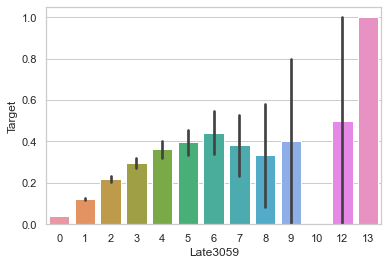

In [13]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Late3059",y="Target",data=train)

In [14]:
for i in range(len(train)):
    if train.Late3059[i] >= 6:
        train.Late3059[i] = 6

<ipython-input-14-600fef3190c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Late3059[i] = 6


In [15]:
print("Max: ", train['DebtRatio'].max())
print("Min: ", train['DebtRatio'].min())
print("Mean: ", train['DebtRatio'].mean())

train.DebtRatio.describe()

Max:  329664.0
Min:  0.0
Mean:  339.3639185508099


count    146473.000000
mean        339.363919
std        2026.556532
min           0.000000
25%           0.173638
50%           0.362659
75%           0.825963
max      329664.000000
Name: DebtRatio, dtype: float64

In [16]:
train['DebtRatio'] = pd.qcut(train.DebtRatio.values, 5).codes
train['DebtRatio'].nunique()

5

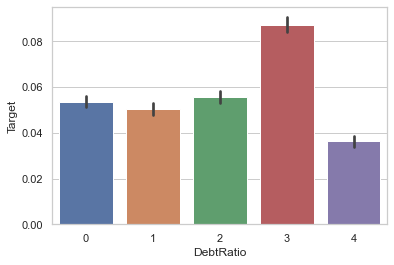

In [17]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="DebtRatio",y="Target",data=train)

In [18]:
print("Max: ", train['MonthlyIncome'].max())
print("Min: ", train['MonthlyIncome'].min())
print("Mean: ", train['MonthlyIncome'].mean())
print("Median: ", train['MonthlyIncome'].median())

train.MonthlyIncome.describe()

Max:  3008750.0
Min:  0.0
Mean:  6688.3676326295845
Median:  5416.0


count    1.182240e+05
mean     6.688368e+03
std      1.446389e+04
min      0.000000e+00
25%      3.406000e+03
50%      5.416000e+03
75%      8.284000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [19]:
train.MonthlyIncome.isnull().sum()

28249

In [20]:
train.MonthlyIncome = train.MonthlyIncome.fillna(train.MonthlyIncome.median())

In [21]:
train.MonthlyIncome.isnull().sum()


0

In [22]:
train.MonthlyIncome.describe()

count    1.464730e+05
mean     6.442977e+03
std      1.300417e+04
min      0.000000e+00
25%      3.915000e+03
50%      5.416000e+03
75%      7.458000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [23]:
train['MonthlyIncome'] = pd.qcut(train.MonthlyIncome.values, 5).codes
train['MonthlyIncome'].nunique()


5

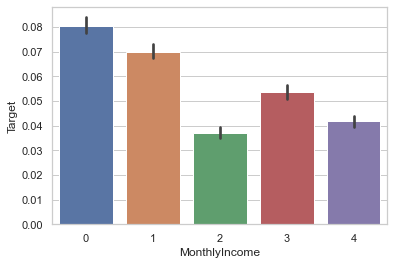

In [24]:

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="MonthlyIncome",y="Target",data=train)

In [25]:
print("Max: ", train['OpenCredit'].max())
print("Min: ", train['OpenCredit'].min())
print("Mean: ", train['OpenCredit'].mean())

train.OpenCredit.describe()

Max:  57
Min:  0
Mean:  8.460289609689157


count    146473.000000
mean          8.460290
std           5.086106
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          57.000000
Name: OpenCredit, dtype: float64

In [26]:
train['OpenCredit'] = pd.qcut(train.OpenCredit.values, 5).codes
train['OpenCredit'].nunique()

5

In [27]:
print("Max: ", train['Late90'].max())
print("Min: ", train['Late90'].min())
print("Mean: ", train['Late90'].mean())

train.Late90.describe()

Max:  17
Min:  0
Mean:  0.06001788725567169


count    146473.000000
mean          0.060018
std           0.378964
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          17.000000
Name: Late90, dtype: float64

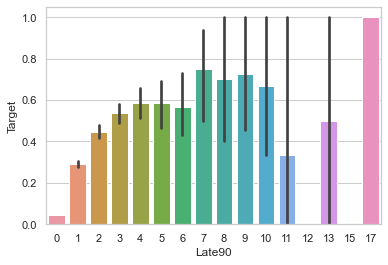

In [28]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Late90",y="Target",data=train)

In [29]:
for i in range(len(train)):
    if train.Late90[i] >= 5:
        train.Late90[i] = 5

<ipython-input-29-035a4376507b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Late90[i] = 5


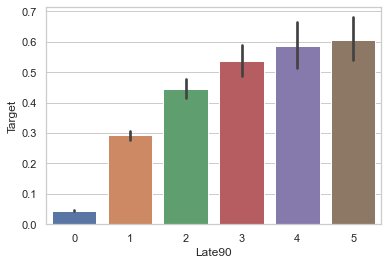

In [30]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Late90",y="Target",data=train)

In [31]:
print("Max: ", train['PropLines'].max())
print("Min: ", train['PropLines'].min())
print("Mean: ", train['PropLines'].mean())

train.PropLines.describe()

Max:  32
Min:  0
Mean:  1.0141391246168237


count    146473.000000
mean          1.014139
std           1.080874
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          32.000000
Name: PropLines, dtype: float64

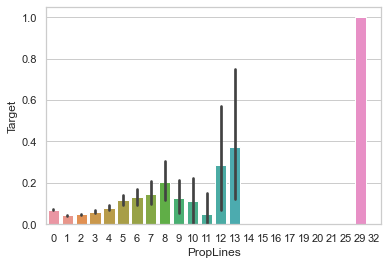

In [32]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="PropLines",y="Target",data=train)

In [33]:
for i in range(len(train)):
    if train.PropLines[i] >= 6:
        train.PropLines[i] = 6

<ipython-input-33-654633ee8649>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.PropLines[i] = 6


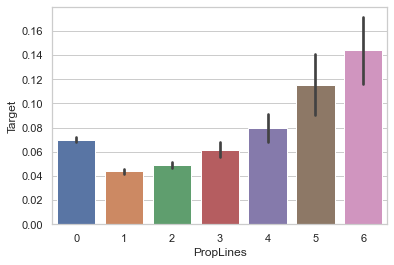

In [34]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="PropLines",y="Target",data=train)

In [35]:
print("Max: ", train['Deps'].max())
print("Min: ", train['Deps'].min())
print("Mean: ", train['Deps'].mean())

train.Deps.describe()

Max:  20.0
Min:  0.0
Mean:  0.7563749500725262


count    142707.000000
mean          0.756375
std           1.113671
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: Deps, dtype: float64

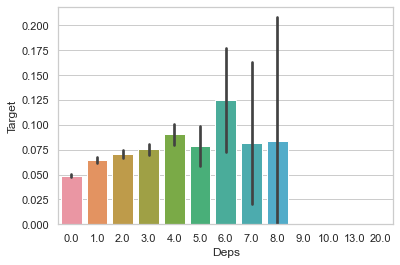

In [36]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Deps",y="Target",data=train)

In [37]:
for i in range(len(train)):
    if train.Deps[i] >= 4:
        train.Deps[i] = 4

<ipython-input-37-d5d2399b1f0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Deps[i] = 4


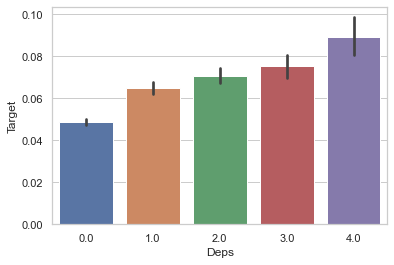

In [38]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Deps",y="Target",data=train)

In [39]:
print("Max: ", train['Late6089'].max())
print("Min: ", train['Late6089'].min())
print("Mean: ", train['Late6089'].mean())

Max:  11
Min:  0
Mean:  0.040396523591378616


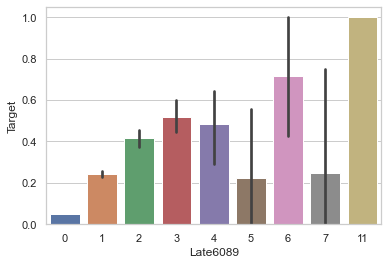

In [40]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Late6089",y="Target",data=train)

In [41]:
for i in range(len(train)):
    if train.Late6089[i] >= 4:
        train.Late6089[i] = 4

<ipython-input-41-f967df9bc3dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Late6089[i] = 4


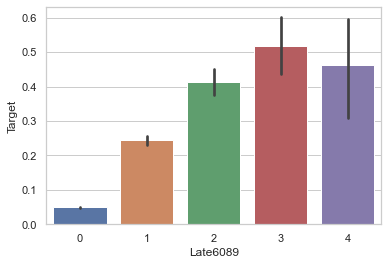

In [42]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Late6089",y="Target",data=train)

In [78]:
def getIVandWOE(filter,bins):
    
    good = train.loc[train['Target'] == 0].groupby(filter).agg({'Target': ['count']}).apply(list)
    good_list = good.to_numpy()

    countGood = []
    sumGood = 0

    for i in range (0,len(good_list)):
        countGood.append(good_list[i][0])
        sumGood += good_list[i]

    #print(countGood)
    # print(sumGood)

    #################################################################################################################

    bad = train.loc[train['Target'] == 1].groupby(filter).agg({'Target': ['count']}).apply(list)
    bad_list = bad.to_numpy()

    countBad = []
    sumBad = 0;

    for i in range (0,len(good_list)):
        countBad.append(bad_list[i][0])
        sumBad += bad_list[i]

    #print(countBad)
    # print(sumBad)

    total=[]
    badRate=[]
    badPercentage=[]
    goodPercentage = []
    quotient =[]
    diff=[]
    woe=[]

    for i in range(0,len(good_list)):
        total.append(countGood[i]+countBad[i])
        badRate.append(countBad[i]/total[i])
        badPercentage.append(countBad[i]/sumBad)
        goodPercentage.append(countGood[i]/sumGood)
        
        if(badPercentage[i] == 0):
            quotient.append(0)
        else:    
            quotient.append(goodPercentage[i]/badPercentage[i])
        
        diff.append(goodPercentage[i]-badPercentage[i])
        
        if(quotient[i]==0):
            woe.append(0)
        else:
            woe.append((np.log(quotient[i]))*100)

    iv = 0;

    for i in range(0,len(good_list)-1):
        if(quotient[i]!=0):
            iv += (diff[i]*(np.log(quotient[i])))

    print("IV: ",iv)

    data = pd.DataFrame()
    data.insert(0,filter,bins)
    data.insert(1,'good',countGood)
    data.insert(2,'bad',countBad)
    data.insert(3,'total_count',total)
    data.insert(4,'dist_bad',badPercentage)
    data.insert(5,'dist_good',goodPercentage)
    data.insert(6,'bad_rate',badRate)
    data.insert(7,'quotient',quotient)
    data.insert(8,'difference',diff)
    data.insert(9,'WoE',woe)
    display(data)
    return float(iv),woe

In [79]:
print("Max age: ", train['age'].max())
print("Min age: ", train['age'].min())

bins_age = [0,10,20,30,40,50,60,70,80,90,100,110]
train['age_bin'] = pd.cut(train['age'], bins = [0,10,20,30,40,50,60,70,80,90,100,110])
binning = []
bin_str = ""
for i in range(0,len(bins_age)-1):
    bin_str = "("+str(bins_age[i])+", "+str(bins_age[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()



Max age:  109
Min age:  0
['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]', '(100, 110]']
11


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_bin
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,"(40, 50]"
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,"(30, 40]"
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,"(30, 40]"
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,"(20, 30]"
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,"(40, 50]"


In [45]:
age_iv,age_woe = getIVandWOE('age_bin',binning)
print(age_iv)



IV:  [0.24585232]


<ipython-input-43-4faeff139b4e>:41: RuntimeWarning: invalid value encountered in longlong_scalars
  badRate.append(countBad[i]/total[i])


,age_bin,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 10]",0,0,0,[0.0],[0.0],NaN,0,[0.0],0
1,"(10, 20]",0,0,0,[0.0],[0.0],NaN,0,[0.0],0
2,"(20, 30]",9312,1048,10360,[0.12631071471616248],[0.06739279898679211],0.101158,[0.5335477606807386],[-0.05891791572937037],[-62.8206688946947]
3,"(30, 40]",21630,1988,23618,[0.23960467638905628],[0.15654061878053194],0.084173,[0.653328729387361],[-0.08306405760852434],[-42.56748623065932]
4,"(40, 50]",31690,2382,34072,[0.2870917198987586],[0.2293468427718473],0.069911,[0.7988626173291423],[-0.05774487712691129],[-22.45662912674574]
5,"(50, 60]",32203,1752,33955,[0.21116066047969145],[0.23305952596345214],0.051598,[1.1037071272367365],[0.021898865483760688],[9.8674629361007]
6,"(60, 70]",26201,785,26986,[0.09461251054598048],[0.1896218563415958],0.029089,[2.0041943211034656],[0.09500934579561533],[69.52421451401555]
7,"(70, 80]",12330,259,12589,[0.031216102205616488],[0.08923466618418673],0.020574,[2.858610136410028],[0.058018563978570234],[105.03355404216738]
8,"(80, 90]",4335,76,4411,[0.009159937326744607],[0.03137325854894156],0.017230,[3.425051660270633],[0.022213321222196953],[123.11165548911328]
9,"(90, 100]",462,6,468,[0.0007231529468482585],[0.0033435860322055364],0.012821,[4.623622218201556],[0.002620433085357278],[153.11784278165052]


0.24585232461408507


In [46]:
print("Max income: ", train['MonthlyIncome'].max())
print("Min income: ", train['MonthlyIncome'].min())
print("Median income: ", train['MonthlyIncome'].median())

train['income_bin'] = pd.cut(train['MonthlyIncome'], bins = [0,1,2,3,4])
# train.head()

bins_income = [0,1,2,3,4]
binning = []
bin_str = ""
for i in range(0,len(bins_income)-1):
    bin_str = "("+str(bins_income[i])+", "+str(bins_income[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max income:  4
Min income:  0
Median income:  2.0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]']
4


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps,age_bin,income_bin
0,1,1,4,45,2,3,4,4,0,6,0,2.0,"(40, 50]","(3.0, 4.0]"
1,2,0,4,40,0,0,0,0,0,0,0,1.0,"(30, 40]",NaN
2,3,0,3,38,1,0,0,0,1,0,0,0.0,"(30, 40]",NaN
3,4,0,2,30,0,0,0,1,0,0,0,0.0,"(20, 30]",NaN
4,5,0,4,49,1,0,4,1,0,1,0,0.0,"(40, 50]","(3.0, 4.0]"


In [47]:
income_iv,income_woe = getIVandWOE('income_bin',binning)
print(income_iv)

IV:  [0.05822343]


,income_bin,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",27042,2036,29078,[0.34397702314580164],[0.24353824816729408],0.070019,[0.708007313802659],[-0.10043877497850756],[-34.530085511202934]
1,"(1, 2]",28204,1089,29293,[0.1839837810440953],[0.2540031340622129],0.037176,[1.3805735082775374],[0.07001935301811762],[32.249899854565136]
2,"(2, 3]",27725,1571,29296,[0.265416455482345],[0.24968929555647615],0.053625,[0.9407453471666342],[-0.015727159925868844],[-6.108279539737282]
3,"(3, 4]",28067,1223,29290,[0.20662274032775807],[0.2527693222140168],0.041755,[1.2233373819989906],[0.04614658188625875],[20.15826829288523]


0.05822342500557432


In [48]:
print("Max Debt Ratio: ", train['DebtRatio'].max())
print("Min Debt Ratio: ", train['DebtRatio'].min())

train['debt_bin'] = pd.cut(train['DebtRatio'], bins = [0,1,2,3,4,5])

bins_debt = [0,1,2,3,4,5]
binning = []
bin_str = ""
for i in range(0,len(bins_debt)-1):
    bin_str = "("+str(bins_debt[i])+", "+str(bins_debt[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max Debt Ratio:  4
Min Debt Ratio:  0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]', '(4, 5]']
5


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps,age_bin,income_bin,debt_bin
0,1,1,4,45,2,3,4,4,0,6,0,2.0,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]"
1,2,0,4,40,0,0,0,0,0,0,0,1.0,"(30, 40]",NaN,NaN
2,3,0,3,38,1,0,0,0,1,0,0,0.0,"(30, 40]",NaN,NaN
3,4,0,2,30,0,0,0,1,0,0,0,0.0,"(20, 30]",NaN,NaN
4,5,0,4,49,1,0,4,1,0,1,0,0.0,"(40, 50]","(3.0, 4.0]",NaN


In [49]:
debt_iv,debt_woe = getIVandWOE('debt_bin',binning)
print(debt_iv)

IV:  [0.11318471]


<ipython-input-43-4faeff139b4e>:41: RuntimeWarning: invalid value encountered in longlong_scalars
  badRate.append(countBad[i]/total[i])


,debt_bin,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",27813,1481,29294,[0.22009213850497844],[0.25181758096497026],0.050556,[1.1441461865721032],[0.031725442459991815],[13.465867025886427]
1,"(1, 2]",27663,1632,29295,[0.2425323227819884],[0.2504594880895255],0.055709,[1.03268498489854],[0.007927165307537093],[3.2162191934769755]
2,"(2, 3]",26741,2553,29294,[0.3794025858225591],[0.2421117438817916],0.087151,[0.6381394142501275],[-0.1372908419407675],[-44.9198501875419]
3,"(3, 4]",28232,1063,29295,[0.15797295289047406],[0.25561118706371266],0.036286,[1.6180693111493158],[0.09763823417323861],[48.12336552647292]
4,"(4, 5]",0,0,0,[0.0],[0.0],NaN,0,[0.0],0


0.11318470575294517


In [50]:
print("Max # unsecured lines: ", train['UnsecuredLines'].max())
print("Min # unsecured lines: ", train['UnsecuredLines'].min())

bins_unsecured = [0,1,2,3,4]
train['unsecured_lines_bin'] = pd.cut(train['UnsecuredLines'], bins = [0,1,2,3,4])
binning = []
bin_str = ""
for i in range(0,len(bins_unsecured)-1):
    bin_str = "("+str(bins_unsecured[i])+", "+str(bins_unsecured[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()



Max # unsecured lines:  4
Min # unsecured lines:  0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]']
4


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps,age_bin,income_bin,debt_bin,unsecured_lines_bin
0,1,1,4,45,2,3,4,4,0,6,0,2.0,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]","(3, 4]"
1,2,0,4,40,0,0,0,0,0,0,0,1.0,"(30, 40]",NaN,NaN,"(3, 4]"
2,3,0,3,38,1,0,0,0,1,0,0,0.0,"(30, 40]",NaN,NaN,"(2, 3]"
3,4,0,2,30,0,0,0,1,0,0,0,0.0,"(20, 30]",NaN,NaN,"(1, 2]"
4,5,0,4,49,1,0,4,1,0,1,0,0.0,"(40, 50]","(3.0, 4.0]",NaN,"(3, 4]"


In [51]:
unsecured_iv,unsecured_woe = getIVandWOE('unsecured_lines_bin',binning)
print(unsecured_iv)

IV:  [0.46133355]


,unsecured_lines_bin,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",28833,461,29294,[0.059224049331963],[0.26357021408852405],0.015737,[4.450391640922064],[0.20434616475656103],[149.2992101501536]
1,"(1, 2]",28518,777,29295,[0.09982014388489209],[0.2606907142987732],0.026523,[2.6116042729750975],[0.16087057041388114],[95.99646964812074]
2,"(2, 3]",27500,1794,29294,[0.23047276464542651],[0.2513849022798325],0.061241,[1.0907358301818373],[0.020912137634405997],[8.68525420427116]
3,"(3, 4]",24543,4752,29295,[0.6104830421377184],[0.22435416933287017],0.162212,[0.36750270498465093],[-0.38612887280484826],[-100.10245998538825]


0.46133355056689257


In [52]:
print("Max # of open credit lines: ", train['OpenCredit'].max())
print("Min # of open credit lines: ", train['OpenCredit'].min())

train['num_open_credit'] = pd.cut(train['OpenCredit'], bins = [0,1,2,3,4])

bins_open_lines = [0,1,2,3,4]
binning = []
bin_str = ""
for i in range(0,len(bins_open_lines)-1):
    bin_str = "("+str(bins_open_lines[i])+", "+str(bins_open_lines[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max # of open credit lines:  4
Min # of open credit lines:  0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]']
4


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps,age_bin,income_bin,debt_bin,unsecured_lines_bin,num_open_credit
0,1,1,4,45,2,3,4,4,0,6,0,2.0,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]","(3, 4]","(3.0, 4.0]"
1,2,0,4,40,0,0,0,0,0,0,0,1.0,"(30, 40]",NaN,NaN,"(3, 4]",NaN
2,3,0,3,38,1,0,0,0,1,0,0,0.0,"(30, 40]",NaN,NaN,"(2, 3]",NaN
3,4,0,2,30,0,0,0,1,0,0,0,0.0,"(20, 30]",NaN,NaN,"(1, 2]","(0.0, 1.0]"
4,5,0,4,49,1,0,4,1,0,1,0,0.0,"(40, 50]","(3.0, 4.0]",NaN,"(3, 4]","(0.0, 1.0]"


In [53]:
num_open_credit_iv,open_credit_woe = getIVandWOE('num_open_credit',binning)
print(num_open_credit_iv)

IV:  [0.00503626]


,num_open_credit,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",37082,1858,38940,[0.3176068376068376],[0.342653853261874],0.047714,[1.0788617016049316],[0.025047015655036364],[7.590650531319082]
1,"(1, 2]",22450,1080,23530,[0.18461538461538463],[0.20744779153576048],0.045899,[1.1236755374853693],[0.02283240692037586],[11.660504208131089]
2,"(2, 3]",23296,1319,24615,[0.22547008547008546],[0.21526520051746442],0.053585,[0.9547395170789742],[-0.010204884952621035],[-4.63167326917261]
3,"(3, 4]",25392,1593,26985,[0.2723076923076923],[0.23463315468490112],0.059033,[0.8616471782213883],[-0.03767453762279119],[-14.890939811468238]


0.005036262125166998


In [54]:
print("Max # times 30-59 days past due: ", train['Late3059'].max())
print("Min # times 30-59 days past due: ", train['Late3059'].min())

train['30to59_days_due_bin'] = pd.cut(train['Late3059'], bins = [0,1,2,3,4,5,6])

bins_30to59_days_due = [0,1,2,3,4,5,6]
binning = []
bin_str = ""
for i in range(0,len(bins_30to59_days_due)-1):
    bin_str = "("+str(bins_30to59_days_due[i])+", "+str(bins_30to59_days_due[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max # times 30-59 days past due:  6
Min # times 30-59 days past due:  0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]', '(4, 5]', '(5, 6]']
6


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps,age_bin,income_bin,debt_bin,unsecured_lines_bin,num_open_credit,30to59_days_due_bin
0,1,1,4,45,2,3,4,4,0,6,0,2.0,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]","(3, 4]","(3.0, 4.0]","(1.0, 2.0]"
1,2,0,4,40,0,0,0,0,0,0,0,1.0,"(30, 40]",NaN,NaN,"(3, 4]",NaN,NaN
2,3,0,3,38,1,0,0,0,1,0,0,0.0,"(30, 40]",NaN,NaN,"(2, 3]",NaN,"(0.0, 1.0]"
3,4,0,2,30,0,0,0,1,0,0,0,0.0,"(20, 30]",NaN,NaN,"(1, 2]","(0.0, 1.0]",NaN
4,5,0,4,49,1,0,4,1,0,1,0,0.0,"(40, 50]","(3.0, 4.0]",NaN,"(3, 4]","(0.0, 1.0]","(0.0, 1.0]"


In [55]:
num30to59_due_iv,num3059days_woe = getIVandWOE('30to59_days_due_bin',binning)
print(num30to59_due_iv)

IV:  [0.21434034]


,30to59_days_due_bin,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",12836,1782,14618,[0.5273749630068068],[0.7391454566394103],0.121905,[1.4015558350081747],[0.21177049363260358],[33.758293029269225]
1,"(1, 2]",2990,842,3832,[0.24918614974844627],[0.17217551537487044],0.219729,[0.6909513853345455],[-0.07701063437357583],[-36.9685811763895]
2,"(2, 3]",980,408,1388,[0.12074578277596922],[0.05643210871818496],0.293948,[0.4673629788204583],[-0.06431367405778426],[-76.06490666458446]
3,"(3, 4]",333,192,525,[0.05682154483575022],[0.019175400207301622],0.365714,[0.3374670692732926],[-0.0376461446284486],[-108.62873459536384]
4,"(4, 5]",145,96,241,[0.02841077241787511],[0.008349648738915121],0.398340,[0.2938902405082729],[-0.02006112367895999],[-122.45489129535623]
5,"(5, 6]",82,59,141,[0.01746078721515241],[0.004721870321317517],0.418440,[0.2704271155208795],[-0.012738916893834894],[-130.77526605477667]


0.2143403365450125


In [56]:
print("Max # times 60-89 days past due: ", train['Late6089'].max())
print("Min # times 60-89 days past due: ", train['Late6089'].min())

train['60to89_days_due_bin'] = pd.cut(train['Late6089'], bins = [0,1,2,3,4])

bins_60to89_days_due = [0,1,2,3,4]
binning = []
bin_str = ""
for i in range(0,len(bins_60to89_days_due)-1):
    bin_str = "("+str(bins_60to89_days_due[i])+", "+str(bins_60to89_days_due[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max # times 60-89 days past due:  4
Min # times 60-89 days past due:  0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]']
4


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps,age_bin,income_bin,debt_bin,unsecured_lines_bin,num_open_credit,30to59_days_due_bin,60to89_days_due_bin
0,1,1,4,45,2,3,4,4,0,6,0,2.0,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]","(3, 4]","(3.0, 4.0]","(1.0, 2.0]",NaN
1,2,0,4,40,0,0,0,0,0,0,0,1.0,"(30, 40]",NaN,NaN,"(3, 4]",NaN,NaN,NaN
2,3,0,3,38,1,0,0,0,1,0,0,0.0,"(30, 40]",NaN,NaN,"(2, 3]",NaN,"(0.0, 1.0]",NaN
3,4,0,2,30,0,0,0,1,0,0,0,0.0,"(20, 30]",NaN,NaN,"(1, 2]","(0.0, 1.0]",NaN,NaN
4,5,0,4,49,1,0,4,1,0,1,0,0.0,"(40, 50]","(3.0, 4.0]",NaN,"(3, 4]","(0.0, 1.0]","(0.0, 1.0]",NaN


In [57]:
num60to89_days_due_iv,num6089days_woe = getIVandWOE('60to89_days_due_bin',binning)
print(num60to89_days_due_iv)

IV:  [0.10916445]


,60to89_days_due_bin,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",3102,998,4100,[0.7486871717929482],[0.877262443438914],0.243415,[1.1717343057155034],[0.12857527164596583],[15.848496384619478]
1,"(1, 2]",342,242,584,[0.18154538634658665],[0.09671945701357466],0.414384,[0.5327563479301447],[-0.08482592933301199],[-62.96910926729067]
2,"(2, 3]",64,69,133,[0.051762940735183796],[0.01809954751131222],0.518797,[0.3496622729359303],[-0.033663393223871574],[-105.07875248164127]
3,"(3, 4]",28,24,52,[0.01800450112528132],[0.007918552036199095],0.461538,[0.43980957767722473],[-0.010085949089082225],[-82.14134237515671]


0.10916445304965827


In [58]:
print("Max # times 90 days late: ", train['Late90'].max())
print("Min # times 90 days late: ", train['Late90'].min())

train['num_90days_late'] = pd.cut(train['Late90'], bins = [0,1,2,3,4,5])

bins_90days_late = [0,1,2,3,4,5]
binning = []
bin_str = ""
for i in range(0,len(bins_90days_late)-1):
    bin_str = "("+str(bins_90days_late[i])+", "+str(bins_90days_late[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max # times 90 days late:  5
Min # times 90 days late:  0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]', '(4, 5]']
5


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps,age_bin,income_bin,debt_bin,unsecured_lines_bin,num_open_credit,30to59_days_due_bin,60to89_days_due_bin,num_90days_late
0,1,1,4,45,2,3,4,4,0,6,0,2.0,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]","(3, 4]","(3.0, 4.0]","(1.0, 2.0]",NaN,NaN
1,2,0,4,40,0,0,0,0,0,0,0,1.0,"(30, 40]",NaN,NaN,"(3, 4]",NaN,NaN,NaN,NaN
2,3,0,3,38,1,0,0,0,1,0,0,0.0,"(30, 40]",NaN,NaN,"(2, 3]",NaN,"(0.0, 1.0]",NaN,"(0.0, 1.0]"
3,4,0,2,30,0,0,0,1,0,0,0,0.0,"(20, 30]",NaN,NaN,"(1, 2]","(0.0, 1.0]",NaN,NaN,NaN
4,5,0,4,49,1,0,4,1,0,1,0,0.0,"(40, 50]","(3.0, 4.0]",NaN,"(3, 4]","(0.0, 1.0]","(0.0, 1.0]",NaN,NaN


In [59]:
num_90days_late_iv,num90days_woe= getIVandWOE('num_90days_late',binning)
print(num_90days_late_iv)

IV:  [0.1508163]


,num_90days_late,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",2776,1146,3922,[0.5750125439036629],[0.7634763476347635],0.292198,[1.3277559867679611],[0.1884638037311006],[28.349028926743543]
1,"(1, 2]",543,438,981,[0.21976919217260413],[0.14933993399339934],0.446483,[0.6795307955453079],[-0.07042925817920478],[-38.63527255270854]
2,"(2, 3]",184,212,396,[0.10637230306071249],[0.050605060506050605],0.535354,[0.4757353093799946],[-0.05576724255466189],[-74.28936521476017]
3,"(3, 4]",69,98,167,[0.04917210235825389],[0.018976897689768978],0.586826,[0.38592813362968953],[-0.03019520466848491],[-95.21041091578873]
4,"(4, 5]",64,99,163,[0.04967385850476668],[0.0176017601760176],0.607362,[0.3543465457656877],[-0.03207209832874908],[-103.74799018594926]


0.15081630302391924


In [60]:
print("Max # real estate loans: ", train['PropLines'].max())
print("Min # real estate loans: ", train['PropLines'].min())

train['num_real_estate_loans'] = pd.cut(train['PropLines'], bins = [0,1,2,3,4,5,6])

bins_num_real_estate_loans = [0,1,2,3,4,5,6]
binning = []
bin_str = ""
for i in range(0,len(bins_num_real_estate_loans)-1):
    bin_str = "("+str(bins_num_real_estate_loans[i])+", "+str(bins_num_real_estate_loans[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max # real estate loans:  6
Min # real estate loans:  0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]', '(4, 5]', '(5, 6]']
6


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,...,Deps,age_bin,income_bin,debt_bin,unsecured_lines_bin,num_open_credit,30to59_days_due_bin,60to89_days_due_bin,num_90days_late,num_real_estate_loans
0,1,1,4,45,2,3,4,4,0,6,...,2.0,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]","(3, 4]","(3.0, 4.0]","(1.0, 2.0]",NaN,NaN,"(5.0, 6.0]"
1,2,0,4,40,0,0,0,0,0,0,...,1.0,"(30, 40]",NaN,NaN,"(3, 4]",NaN,NaN,NaN,NaN,NaN
2,3,0,3,38,1,0,0,0,1,0,...,0.0,"(30, 40]",NaN,NaN,"(2, 3]",NaN,"(0.0, 1.0]",NaN,"(0.0, 1.0]",NaN
3,4,0,2,30,0,0,0,1,0,0,...,0.0,"(20, 30]",NaN,NaN,"(1, 2]","(0.0, 1.0]",NaN,NaN,NaN,NaN
4,5,0,4,49,1,0,4,1,0,1,...,0.0,"(40, 50]","(3.0, 4.0]",NaN,"(3, 4]","(0.0, 1.0]","(0.0, 1.0]",NaN,NaN,"(0.0, 1.0]"


In [61]:
num_real_estate_loans_iv,estate_loans_woe= getIVandWOE('num_real_estate_loans',binning)
print(num_real_estate_loans_iv)

IV:  [0.02936979]


,num_real_estate_loans,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",49091,2247,51338,[0.5006684491978609],[0.5611554376900391],0.043769,[1.1208124629963931],[0.06048698849217815],[11.405383571152123]
1,"(1, 2]",29488,1523,31011,[0.339349376114082],[0.33707505543997623],0.049112,[0.9932979965952813],[-0.0022743206741057675],[-0.6724562680930537]
2,"(2, 3]",5813,381,6194,[0.08489304812834225],[0.06644795500788733],0.061511,[0.7827255172582633],[-0.01844509312045492],[-24.497319712072382]
3,"(3, 4]",1962,170,2132,[0.03787878787878788],[0.02242747079399191],0.079737,[0.5920852289613864],[-0.015451317084795971],[-52.41046866203266]
4,"(4, 5]",598,78,676,[0.017379679144385027],[0.006835691913765117],0.115385,[0.39331519626894673],[-0.01054398723061991],[-93.31439624343334]
5,"(5, 6]",530,89,619,[0.019830659536541888],[0.006058389154340322],0.143780,[0.30550618567055465],[-0.013772270382201565],[-118.57852528813456]


0.0293697860158444


In [62]:
print("Max # dependents: ", train['Deps'].max())
print("Min # dependents: ", train['Deps'].min())

train['deps_bin'] = pd.cut(train['Deps'], bins = [0,1,2,3,4])

bins_deps = [0,1,2,3,4]
binning = []
bin_str = ""
for i in range(0,len(bins_deps)-1):
    bin_str = "("+str(bins_deps[i])+", "+str(bins_deps[i+1])+"]"
    binning.append(bin_str)
    
print(binning)
print(len(binning))
train.head()

Max # dependents:  4.0
Min # dependents:  0.0
['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]']
4


,Unknown,Target,UnsecuredLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,...,age_bin,income_bin,debt_bin,unsecured_lines_bin,num_open_credit,30to59_days_due_bin,60to89_days_due_bin,num_90days_late,num_real_estate_loans,deps_bin
0,1,1,4,45,2,3,4,4,0,6,...,"(40, 50]","(3.0, 4.0]","(2.0, 3.0]","(3, 4]","(3.0, 4.0]","(1.0, 2.0]",NaN,NaN,"(5.0, 6.0]","(1.0, 2.0]"
1,2,0,4,40,0,0,0,0,0,0,...,"(30, 40]",NaN,NaN,"(3, 4]",NaN,NaN,NaN,NaN,NaN,"(0.0, 1.0]"
2,3,0,3,38,1,0,0,0,1,0,...,"(30, 40]",NaN,NaN,"(2, 3]",NaN,"(0.0, 1.0]",NaN,"(0.0, 1.0]",NaN,NaN
3,4,0,2,30,0,0,0,1,0,0,...,"(20, 30]",NaN,NaN,"(1, 2]","(0.0, 1.0]",NaN,NaN,NaN,NaN,NaN
4,5,0,4,49,1,0,4,1,0,1,...,"(40, 50]","(3.0, 4.0]",NaN,"(3, 4]","(0.0, 1.0]","(0.0, 1.0]",NaN,NaN,"(0.0, 1.0]",NaN


In [63]:
bins_deps_iv,deps_woe= getIVandWOE('deps_bin',binning)
print(bins_deps_iv)

IV:  [0.00406297]


,deps_bin,good,bad,total_count,dist_bad,dist_good,bad_rate,quotient,difference,WoE
0,"(0, 1]",24116,1671,25787,[0.41259259259259257],[0.4484194867980662],0.064800,[1.0868335855967495],[0.035826894205473636],[8.326850129163178]
1,"(1, 2]",17719,1350,19069,[0.3333333333333333],[0.3294719226478245],0.070796,[0.9884157679434735],[-0.003861410685508826],[-1.1651851996676508]
2,"(2, 3]",8539,696,9235,[0.17185185185185184],[0.1587764968389736],0.075365,[0.9239149600543723],[-0.013075355012878237],[-7.91352461490842]
3,"(3, 4]",3406,333,3739,[0.08222222222222222],[0.06333209371513573],0.089061,[0.7702551938327319],[-0.01889012850708649],[-26.103339848008115]


0.004062965809660352


<AxesSubplot:xlabel='IV', ylabel='name'>

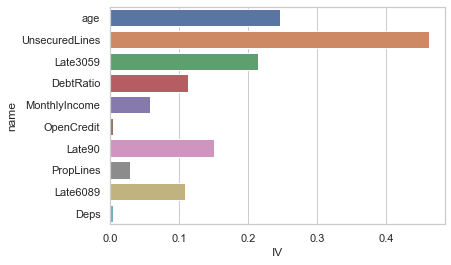

In [64]:
sns.set_color_codes("pastel")

values = {'name':['age','UnsecuredLines','Late3059','DebtRatio','MonthlyIncome','OpenCredit','Late90','PropLines','Late6089','Deps'],
          'IV':[age_iv,unsecured_iv,num30to59_due_iv,debt_iv,income_iv,num_open_credit_iv,num_90days_late_iv,
                num_real_estate_loans_iv,num60to89_days_due_iv,bins_deps_iv]}

iv_values = pd.DataFrame(data=values)

sns.barplot(x="IV", y="name", data=iv_values)


In [72]:
def createWoeList(woe):
    regressionList = []
    for i in range(0, len(woe)):
        if(isinstance(woe[i], int)):
            regressionList.append(0)
        else:
            current = woe[i].tolist()
            regressionList.append(current[0])
    return regressionList

In [74]:
ageRegressionList = []
ageRegressionList = createWoeList(age_woe)
print("AGE REGRESSION LIST: ",ageRegressionList)

AGE REGRESSION LIST:  [0, 0, -62.8206688946947, -42.56748623065932, -22.45662912674574, 9.8674629361007, 69.52421451401555, 105.03355404216738, 123.11165548911328, 153.11784278165052, -32.772034424917805]


In [75]:
debtRegressionList = []
debtRegressionList = createWoeList(debt_woe)
print("DEBT RATIO REGRESSION LIST: ",debtRegressionList)

DEBT RATIO REGRESSION LIST:  [13.465867025886427, 3.2162191934769755, -44.9198501875419, 48.12336552647292, 0]


In [76]:
incomeRegressionList = []
incomeRegressionList = createWoeList(income_woe)
print("MONTHLY INCOME RATIO REGRESSION LIST: ",incomeRegressionList)

MONTHLY INCOME RATIO REGRESSION LIST:  [-34.530085511202934, 32.249899854565136, -6.108279539737282, 20.15826829288523]


In [128]:
X = train[['age','UnsecuredLines','Late3059','DebtRatio','MonthlyIncome','OpenCredit','Late90','PropLines','Late6089','Deps']]
y = train['Target']
X = X.values.astype(np.float)
y = y.values.astype(np.float)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=0)

logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

# print (X_test) #test dataset
print (y_pred) #predicted values

[0. 0. 0. ... 0. 0. 0.]


In [142]:
clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
clf.fit(X, y)
test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
pd.DataFrame(data={'variable': ['intercept','age','UnsecuredLines','Late3059','DebtRatio','MonthlyIncome','OpenCredit','Late90','PropLines','Late6089','Deps','Target'], 'coefficient': coefficients})


ValueError: arrays must all be same length

(145442, 13)
(417, 13)

0    0.944851
1    0.055149
Name: Target, dtype: float64

1    1.0
Name: Target, dtype: float64


TypeError: float() argument must be a string or a number, not 'builtin_function_or_method'

In [108]:
coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + cat_cols + numeric_cols, 'coefficient': coefficients})

AttributeError: 'LogisticRegression' object has no attribute 'intercept_'